## Topography spectrum comparison across resolution
#### Topography acutally used in the model

In [1]:
%matplotlib inline
import math
import numpy as np
import xarray as xr
import netCDF4 as nc

import cmocean as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
import matplotlib.gridspec as gridspec

from gsw import f
from matplotlib.colors import LogNorm
from dask.distributed import Client
from scipy.fftpack import fft2, fftshift

In [2]:
def fft_topog(topog,delta_lon,delta_lat,alpha=0.8,border=0.9,k_grid_units=True):

    ydim, xdim = topog.dims
    nx = topog[xdim].size
    ny = topog[ydim].size
    dx = np.mean(np.diff(topog[xdim]))*delta_lon*1e+3
    dy = np.mean(np.diff(topog[ydim]))*delta_lat*1e+3

    # demean
    topog -= topog.mean(skipna=True) 

    # windowing
    topog_filt = windowing(topog,alpha=0.8,border=0.9)

    # FFT
    topog_fft = fft2(topog_filt.values)
    topog_spd = (topog_fft*topog_fft.conjugate()).real
    topog_spd[0,0] = np.nan          # nan at removed zero frequency
    topog_spd = fftshift(topog_spd)  # put zero wavenumber in array centre
    topog_spd *= dx*dy

    if (k_grid_units):
        # k in units cycles/dx:
        topog_spd = xr.DataArray(topog_spd, dims=['ky','kx'], 
                                 coords={'ky': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny), 
                                         'kx': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)},
                                 attrs={'long_name': 'wavenumber spectrum in grid units'})
        topog_spd.kx.attrs['units'] = 'cycles/dx'
        topog_spd.ky.attrs['units'] = 'cycles/dy'
        topog_spd.kx.attrs['long_name'] = 'x wavenumber'
        topog_spd.ky.attrs['long_name'] = 'y wavenumber'

        # No rescaling

    else:
        # k in units cycles/(units of dx)
        topog_spd = xr.DataArray(topog_spd, dims=['ky','kx'], 
                                 coords={'ky': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny)*(2*np.pi/dy),
                                         'kx': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)*(2*np.pi/dx)},
                                 attrs={'long_name': 'wavenumber spectrum in grid units'})
        topog_spd.kx.attrs['units'] = 'radians/meters'
        topog_spd.ky.attrs['units'] = 'radians/meters'
        topog_spd.kx.attrs['long_name'] = 'x wavenumber'
        topog_spd.ky.attrs['long_name'] = 'y wavenumber'

        # Rescale to satisfy Parseval's theorem:
        topog_spd /= 4*np.pi**2./dx/dy

    return topog_spd, dx, dy

In [3]:
def windowing(topog_sample, alpha=0.8, border=1):

    # shape parameter of the Tukey window (flat + cosine tapered region)
    # - raidus < alpha, factor = 1
    # - alpha < radius < alpha, factor decays from 1 to 0
    # - radius > border, factor = 0
    
    vari = np.var(topog_sample)

    ydim, xdim = topog_sample.dims
    nx = topog_sample[xdim].size
    ny = topog_sample[ydim].size

    # Create coordinate grid
    y = np.linspace(-1, 1, ny)
    x = np.linspace(-1, 1, nx)
    xv, yv = np.meshgrid(x, y)
    
    # Calculate radial distance from the center
    r = np.sqrt(xv**2 + yv**2)
    
    # Initialize the window with zeros
    window = np.zeros((ny, nx))
    
    # Apply Tukey window formula
    for j in range(ny):
        for i in range(nx):
            if r[j, i] <= alpha:
                window[j, i] = 1
            elif r[j, i] <= border:
                window[j, i] = 0.5*(1 + np.cos( np.pi * (r[j, i] - alpha ) / (border - alpha) ))
            else:
                window[j, i] = 0

    topog_filt = topog_sample * window
    varf = np.var(topog_filt)
    fac  = np.sqrt(vari/varf).values
    window *= fac
    topog_filt *= fac

    return topog_filt

In [23]:
def get_delta(lat, nx, ny):

    # compute the distance in km at this lon and lat
    delta_lon = 2 * np.pi * (6371 * np.cos(lat*np.pi/180)) / nx
    delta_lat = 1 * np.pi * 6371 / ny
    
    return delta_lon, delta_lat

In [5]:
def azimuthal_sum(topog_spd):  
    
    # following DurranWeynMenchaca2017a http://dx.doi.org/10.1175/MWR-D-17-0056.1
    # omits zero wavenumber
    dkh = np.max([np.max(np.diff(topog_spd.kx)), np.max(np.diff(topog_spd.ky))])
    dkmin = np.min([np.min(np.diff(topog_spd.kx)), np.min(np.diff(topog_spd.ky))])
    
    # extends sqrt(2) times further to get into corners
    Nmax = int(np.ceil(np.sqrt(2)*max(topog_spd.shape)/2))  
    kp = dkh*range(1,Nmax+1)
    
    # number of wavenumber points in each annulus (C in DurranWeynMenchaca2017a)
    C = 0.0*kp  
    fftradial = 0.0*kp
    radius = np.sqrt(topog_spd.kx**2+topog_spd.ky**2)
    ones = 1 + 0*topog_spd
    
    # sum in each annulus
    for i,k in enumerate(kp):
        fftradial[i] = topog_spd.where(radius>=k-dkh/2).where(radius<k+dkh/2).sum()
        C[i] = ones.where(radius>k-dkh/2).where(radius<=k+dkh/2).sum()

    # scale as in eq (24) (assuming scaling in eq (22) is already done)
    fftradial *= dkmin  

    # eq (26): compensate for number of (k,l) pairs in each annulus
    # Parseval's theorem no longer exactly holds (p 3905)
    C = np.where(C==0, 1, C)  # ensures no division by zero (fftradial=0 there anyway)
    fftradial *= 2.0*np.pi*kp/C/dkmin

    fftradial = xr.DataArray(fftradial, dims=['k'], coords={'k': kp})
    fftradial.k.attrs['units'] = topog_spd.kx.attrs['units']
    fftradial.k.attrs['long_name'] = 'wavenumber magnitude'

    # Truncate spectrum at Nyquist frequency (high k's in corners are anisotropically sampled):
    # Also breaks Parseval's theorem
    kminmax = np.min([np.max(topog_spd.kx), np.max(topog_spd.ky)])
    fftradial = fftradial.sel(k=slice(0.,kminmax))    

    return fftradial

In [6]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41917,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:34203,Total threads: 2
Dashboard: /proxy/39769/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:33531,


### Step 0: Read data

In [7]:
topog_dir = '/g/data/nm03/lxy581/input/'
topog_004 = xr.open_dataset(topog_dir + 'tides_004deg_drag_coeff/ocean_topog.nc')
topog_008 = xr.open_dataset(topog_dir + 'tides_008deg_drag_coeff/ocean_topog.nc')
topog_010 = xr.open_dataset(topog_dir + 'tides_01deg_drag_coeff/ocean_topog.nc')
topog_025 = xr.open_dataset(topog_dir + 'tides_025deg_drag_coeff/ocean_topog.nc')
hgrid_025 = xr.open_dataset(topog_dir + 'tides_025deg_drag_coeff/ocean_hgrid.nc')

In [8]:
depth_004 = topog_004.depth
depth_008 = topog_008.depth
depth_010 = topog_010.depth
depth_025 = topog_025.depth

### Plot around Australia, decide where to sample

In [9]:
topog_4km = xr.open_dataset('/g/data/nm03/lxy581/input/tides_004deg_drag_coeff/ocean_topog.nc')
depth_4km = np.array(topog_4km.depth)
depth_4km[depth_4km==0]=np.nan

grid_4km = xr.open_dataset('/scratch/nm03/lxy581/mom6/archive/tides_004_global_sigma_x06/output002/ocean_static.nc')
lon_4km = np.array(grid_4km['geolon'])
lat_4km = np.array(grid_4km['geolat'])
yh, xh = grid_4km.yh, grid_4km.xh
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_4km),
                                }, 
                      coords={'lon': (('yh', 'xh'), lon_4km),
                              'lat': (('yh', 'xh'), lat_4km)})
land_4km = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

Start plotting...
0
Plotting 4km topog...


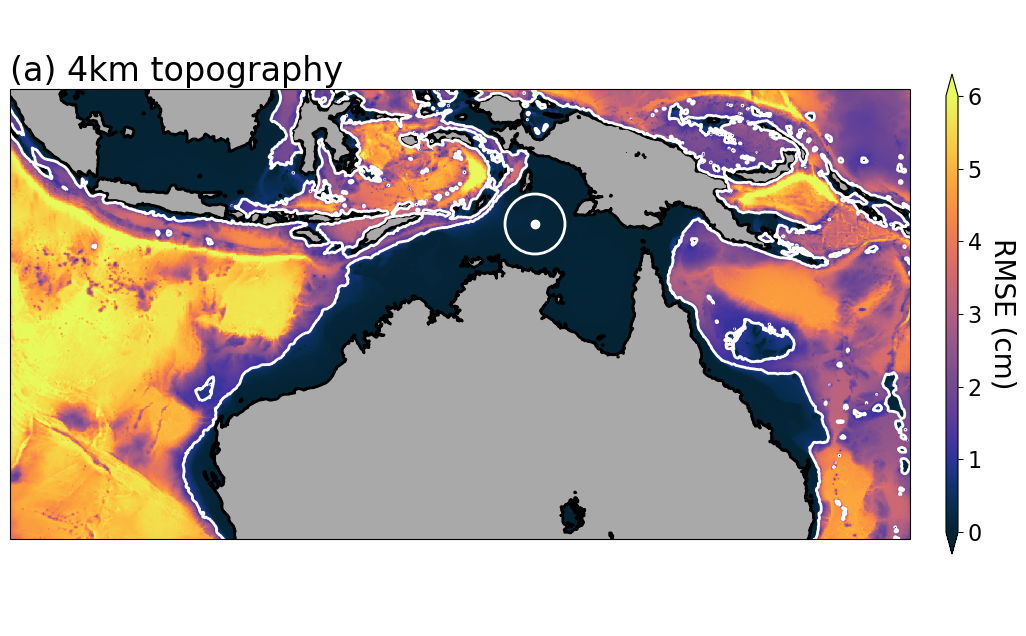

In [10]:
lon = ['lon_4km']
lat = ['lat_4km']

varlist = ['depth_004']
title   = ['(a) 4km topography']

# RMSE
tick_locs = np.array([0,1000,2000,3000,4000,5000,6000])
tick_labels = np.array(["0","1","2","3","4","5","6"])

fig = plt.figure(figsize=(12, 8))
axs = []

gridsubs = gridspec.GridSpec(1,1)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

print('Start plotting...')
for I, (ax, var) in enumerate(zip(axs, varlist)):
    print(I)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    if I==0:
        print('Plotting 4km topog...')
        # ax = plt.axes(projection=ccrs.Robinson(central_longitude=-80))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent([100, 160, -30, 0], crs=ccrs.PlateCarree())
        # Add model land mask
        land_4km.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
        # Add model coastline
        land_4km.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=2)
        p1 = ax.pcolormesh(globals()[lon[I]], globals()[lat[I]], globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.thermal, vmin=0, vmax=6000) #norm=LogNorm(vmin=1e-2, vmax=1e-0)
        ax.contour(globals()[lon[I]], globals()[lat[I]], globals()[var], colors='w',levels=np.array([1000.0,]), linewidths=2)
        ax.plot(135, -9, marker='o', color='white', markersize=6, transform=ccrs.PlateCarree())
        circle = Circle((135, -9), radius=2, facecolor='none', edgecolor='white', linewidth=2, transform=ccrs.PlateCarree())
        ax.add_patch(circle)
        ax_cb = plt.axes([0.88, 0.2, 0.01, 0.6])
        cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb1.ax.set_ylabel('RMSE (cm)',fontsize=20,rotation=270,labelpad=25);
        cb1.ax.tick_params(labelsize=16)
        cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
        ax.set_position([0.1,0.1,0.75,0.8])
        ax.set_title(title[I],fontsize=24,loc="left")

### Step 1: Sample the same region in shelf regions (lon: 135, lat: -9, radius: 2-deg)

In [11]:
# 4km (-225; -9) 1deg = 24points in x, 36.3points in y
x_04k = 1800; y_04k = 2865
print('[4km] Lon: %.1f ;' % topog_004.geolon_t[y_04k, x_04k].values,'Lat: %.1f .' % topog_004.geolat_t[y_04k, x_04k].values)
lon_sample_004 = topog_004.geolon_t[y_04k-49:y_04k+49,x_04k-49:x_04k+49]
lat_sample_004 = topog_004.geolat_t[y_04k-49:y_04k+49,x_04k-49:x_04k+49]
topog_sample_004 = depth_004[y_04k-49:y_04k+49,x_04k-49:x_04k+49]
print('array size: ', topog_sample_004.shape)
print('lon min: %.2f, lon max: %.2f' % (lon_sample_004.min().values, lon_sample_004.max().values))
print('lat min: %.2f, lat max: %.2f' % (lat_sample_004.min().values, lat_sample_004.max().values))
print('Depth: %.2f' % depth_004[y_04k,x_04k])
print('Depth mean: %.2f' % topog_sample_004.mean().values)
print(' ')

# 8km (-225; -9)
x_08k = 900; y_08k = 1432
print('[8km] Lon: %.1f ;' % topog_008.geolon_t[y_08k, x_08k].values,'Lat: %.1f .' % topog_008.geolat_t[y_08k, x_08k].values)
lon_sample_008 = topog_008.geolon_t[y_08k-25:y_08k+25,x_08k-25:x_08k+25]
lat_sample_008 = topog_008.geolat_t[y_08k-25:y_08k+25,x_08k-25:x_08k+25]
topog_sample_008 = depth_008[y_08k-25:y_08k+25,x_08k-25:x_08k+25]
print('array size: ', topog_sample_008.shape)
print('lon min: %.2f, lon max: %.2f' % (lon_sample_008.min().values, lon_sample_008.max().values))
print('lat min: %.2f, lat max: %.2f' % (lat_sample_008.min().values, lat_sample_008.max().values))
print('Depth: %.2f' % depth_008[y_08k,x_08k])
print('Depth mean: %.2f' % topog_sample_008.mean().values)
print(' ')

# 10km (-225; -9)
x_10k = 550; y_10k = 1253
print('[10km] Lon: %.1f ;' % topog_010.geolon_t[y_10k, x_10k].values,'Lat: %.1f .' % topog_010.geolat_t[y_10k, x_10k].values)
lon_sample_010 = topog_010.geolon_t[y_10k-21:y_10k+21,x_10k-21:x_10k+21]
lat_sample_010 = topog_010.geolat_t[y_10k-21:y_10k+21,x_10k-21:x_10k+21]
topog_sample_010 = depth_010[y_10k-21:y_10k+21,x_10k-21:x_10k+21]
print('array size: ', topog_sample_010.shape)
print('lon min: %.2f, lon max: %.2f' % (lon_sample_010.min().values, lon_sample_010.max().values))
print('lat min: %.2f, lat max: %.2f' % (lat_sample_010.min().values, lat_sample_010.max().values))
print('Depth: %.2f' % depth_010[y_10k,x_10k])
print('Depth mean: %.2f' % topog_sample_010.mean().values)
print(' ')

# 25km (-225; -9)
x_25k = 600; y_25k = 935
print('[25km] Lon: %.1f ;' % hgrid_025.x[y_25k, x_25k].values,'Lat: %.1f .' % hgrid_025.y[y_25k, x_25k].values)
lon_sample_025 = hgrid_025.x[y_25k-17:y_25k+17,x_25k-17:x_25k+17]
lat_sample_025 = hgrid_025.y[y_25k-17:y_25k+17,x_25k-17:x_25k+17]
topog_sample_025 = depth_025[468-9:468+8,300-9:300+8]
print('array size: ', topog_sample_025.shape)
print('lon min: %.2f, lon max: %.2f' % (lon_sample_025.min().values, lon_sample_025.max().values))
print('lat min: %.2f, lat max: %.2f' % (lat_sample_025.min().values, lat_sample_025.max().values))
print('Depth: %.2f' % depth_025[468,300])
print('Depth mean: %.2f' % topog_sample_025.mean().values)


[4km] Lon: -225.0 ; Lat: -9.0 .
array size:  (98, 98)
lon min: -227.02, lon max: -222.98
lat min: -10.97, lat max: -6.98
Depth: 88.12
Depth mean: 79.07
 
[8km] Lon: -225.0 ; Lat: -9.0 .
array size:  (50, 50)
lon min: -227.04, lon max: -222.96
lat min: -11.01, lat max: -6.98
Depth: 89.94
Depth mean: 79.05
 
[10km] Lon: -224.9 ; Lat: -9.0 .
array size:  (42, 42)
lon min: -227.05, lon max: -222.95
lat min: -11.03, lat max: -6.98
Depth: 90.53
Depth mean: 79.09
 
[25km] Lon: -225.0 ; Lat: -9.0 .
array size:  (17, 17)
lon min: -227.12, lon max: -223.00
lat min: -11.06, lat max: -6.98
Depth: 88.83
Depth mean: 77.81


### Step 2: Perform spectral analysis and obtain 1D wavenumber spectra

In [24]:
delta_lon_004, delta_lat_004 = get_delta(-9, topog_004.nx.size, topog_004.ny.size)
delta_lon_008, delta_lat_008 = get_delta(-9, topog_008.nx.size, topog_008.ny.size)
delta_lon_010, delta_lat_010 = get_delta(-9, topog_010.nx.size, topog_010.ny.size)
delta_lon_025, delta_lat_025 = get_delta(-9, topog_025.nx.size, topog_025.ny.size)

spd_2d_004, dx_004, dy_004 = fft_topog(topog_sample_004,delta_lon_004,delta_lat_004,k_grid_units=False)
spd_1d_004 = azimuthal_sum(spd_2d_004)

spd_2d_008, dx_008, dy_008 = fft_topog(topog_sample_008,delta_lon_008,delta_lat_008,k_grid_units=False)
spd_1d_008 = azimuthal_sum(spd_2d_008)

spd_2d_010, dx_010, dy_010 = fft_topog(topog_sample_010,delta_lon_010,delta_lat_010,k_grid_units=False)
spd_1d_010 = azimuthal_sum(spd_2d_010)

spd_2d_025, dx_025, dy_025 = fft_topog(topog_sample_025,delta_lon_025,delta_lat_025,k_grid_units=False)
spd_1d_025 = azimuthal_sum(spd_2d_025)

### Step 3: Plot the wavenumber spectrum

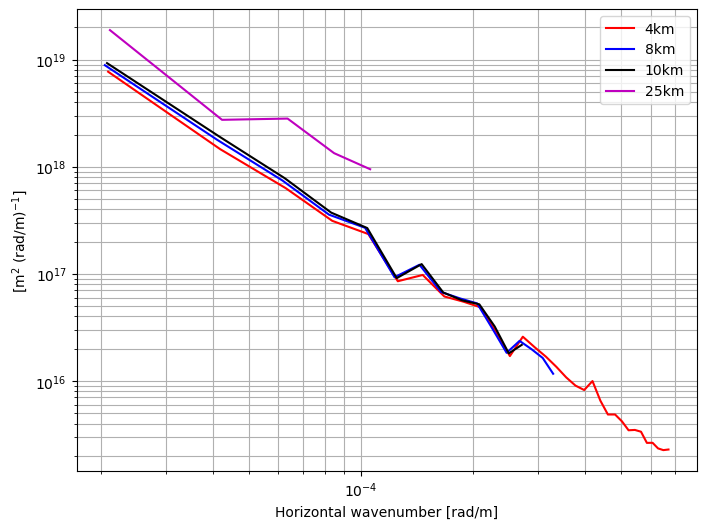

In [25]:
fig = plt.figure(figsize = (8,6))
plt.loglog(spd_1d_004.k, spd_1d_004, 'r', label='4km')
plt.loglog(spd_1d_008.k, spd_1d_008, 'b', label='8km')
plt.loglog(spd_1d_010.k, spd_1d_010, 'k', label='10km')
plt.loglog(spd_1d_025.k, spd_1d_025, 'm', label='25km')
plt.legend(loc=0)
plt.xlabel('Horizontal wavenumber [rad/m]')
plt.ylabel('[m$^{2}$ (rad/m)$^{-1}$]')
plt.grid(which='both', axis='both')

In [26]:
print(dx_004, dx_008, dx_010, dx_025)

4576.080524173429 9152.161048346858 10982.593258016228 27456.483145040573
